# Muon Train 

- 实现 Toy Model
- 实现 Muon 优化器
- 实现 Adam 优化器
- 实现 Muon + Adam 优化器混合训练

In [100]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
torch.manual_seed(42)

## Language Model

In [101]:
class RMSNorm(nn.Module):
    def __init__(self, dim, ):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(dim))
        self.epsilon = 1e-8
    def forward(self, X, ):
        bs, seq_len, dim = X.shape
        RMS = torch.rsqrt((X ** 2).mean(dim = -1, keepdim = True) + self.epsilon) # root-mean-square
        X_norm = X * RMS 
        Y = X_norm * self.gamma
        return Y
        
dim = 4
model = RMSNorm(dim)
X = torch.randn(2,3,4)
model(X)

class SwiGLU(nn.Module):
    def __init__(self, dim, ):
        super().__init__()
        self.dim = dim
        self.W_up = nn.Linear(self.dim, 4 * self.dim, bias = None)
        self.W_act = nn.Linear(self.dim, 4 * self.dim, bias = None)
        self.W_down = nn.Linear(4 * self.dim, self.dim, bias = None)
    def forward(self, X):
        bs, seq_len, dim = X.shape
        V = self.W_up(X)
        G = self.W_act(X)
        A = G * F.sigmoid(G)
        V = A * V
        Y = self.W_down(V)
        return Y
model = SwiGLU(dim)
model(X)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, ):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.head_dim = self.dim / self.heads
        
        # Attention, ignore RoPE
        self.Wq = nn.Linear(self.dim, self.dim, bias = None) 
        self.Wk = nn.Linear(self.dim, self.dim, bias = None)
        self.Wv = nn.Linear(self.dim, self.dim, bias = None)
        self.Wo = nn.Linear(self.dim, self.dim, bias = None)
        
    def forward(self, X):
        bs, seq_len, dim = X.shape
        Q, K, V = self.Wq(X), self.Wk(X), self.Wv(X)
        S = Q @ K.transpose(1,2) / math.sqrt(self.dim)
        P = F.softmax(S, dim = -1)
        Z = P @ V
        O = self.Wo(Z)
        return O
model = Attention(dim, )
model(X)

tensor([[[-0.2139, -0.2678, -0.0288, -0.2496],
         [-0.2532, -0.1282, -0.1340, -0.3112],
         [-0.2583, -0.2086, -0.0908, -0.3082]],

        [[-0.0852,  0.2841, -0.1174, -0.1573],
         [ 0.0087,  0.3686, -0.0410, -0.0982],
         [-0.0333,  0.3283, -0.0755, -0.1234]]], grad_fn=<UnsafeViewBackward0>)

In [102]:
class DecoderBlocker(nn.Module):
    def __init__(self, dim, heads = 8, ):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.head_dim = self.dim / self.heads

        self.RMS_Norm_1 = RMSNorm(self.dim)
        self.Attn = Attention(self.dim)
        self.RMS_Norm_2 = RMSNorm(self.dim)
        self.SwiGLU = SwiGLU(self.dim)

    def forward(self, X, ): # ignore mask
        bs, seq_len, dim = X.shape
        X_ = self.RMS_Norm_1(X)
        X = self.Attn(X_) + X
        X_ = self.RMS_Norm_2(X)
        X = self.SwiGLU(X_) + X
        return X

model = DecoderBlocker(dim, )
model(X)

tensor([[[ 1.9263,  1.7937,  0.8526, -1.7839],
         [ 0.7646, -0.8935, -0.1909, -1.6780],
         [ 0.4675, -0.4409, -0.7441,  0.2292]],

        [[-1.3595,  0.2932, -2.1115,  0.0472],
         [-0.4249, -0.2549,  0.8176, -0.4908],
         [-0.8227,  0.1036, -0.7674,  0.6134]]], grad_fn=<AddBackward0>)

In [103]:
class LanguageModel(nn.Module):
    def __init__(self, 
                 dim, 
                 heads = 8, 
                 vocab_size = 100,
                 num_layers = 4):
        super().__init__()
        self.dim = dim
        self.embedding = nn.Embedding(vocab_size, dim)
        self.decoder = nn.ModuleList(
            [DecoderBlocker(dim, heads) for i in range(num_layers)]
        )
        self.RMS_Norm = RMSNorm(self.dim)
        self.LM_head = nn.Linear(dim, vocab_size, bias = None)
        
    def forward(self, input_ids):
        X = self.embedding(input_ids)

        for decode_block in self.decoder:
            X = decode_block(X)
            
        Y = self.RMS_Norm(X)
        logits = self.LM_head(Y)
        return logits

input_ids = torch.ones(2,3, dtype = torch.long)
model = LanguageModel(dim, )
logits = model(input_ids)
print(logits.shape)

torch.Size([2, 3, 100])


## Config

In [118]:
dim = 512 
vocab_size = 100
num_layers = 4
heads = 8

seq_len = 128


# batch_size = 16
# N = 8192 # dataset
batch_size = 8
N = 1024 # dataset

## Dummy Dataset

pretrain dataset

In [119]:
X = torch.randint(2, vocab_size-1, (N, seq_len), dtype = torch.long) 
X[:, 0] = 0 # <SOS>
X[:, seq_len - 1] = 1 # <PAD> or <EOS>
print(X.shape)
print(X[0,:])

torch.Size([1024, 128])
tensor([ 0, 12, 60, 90, 49, 11,  2, 64, 31, 40, 41, 81, 73, 75,  9, 18, 96, 25,
        67,  2, 78, 96, 53,  5,  7, 96, 50,  3, 77, 84, 36, 67, 68, 82, 40, 65,
        47, 20, 76, 57, 41, 52, 35,  4,  5, 23, 71, 93, 13, 60, 91, 26, 95, 94,
        83, 73, 40, 29, 16, 83, 73, 72, 28, 58,  8, 70, 34, 23, 65, 21, 20, 47,
        10, 55,  9, 67, 62,  9, 56, 55, 97, 79, 77, 45, 41, 61, 46, 26, 86, 59,
         4, 86, 73, 52, 86, 21, 39, 86, 27, 37, 46, 85, 64, 85, 94, 32, 16,  3,
        53, 94, 71, 92, 94, 91, 93, 15, 26,  5, 60, 63, 38, 46, 72, 71, 12, 31,
        64,  1])


In [120]:
from torch.utils.data  import TensorDataset, DataLoader

train_dataset = TensorDataset(X)

def collate_fn(batch):

    batch = [ torch.unsqueeze(b[0], dim = 0) for b in batch ]

    input_ids = torch.concat(batch, dim = 0)
    label = torch.roll(input_ids, shifts = -1)
    label[:, -1] = -100 # ignore 
    
    return {'input_ids': input_ids, 'label': label}

train_dataloader = DataLoader(train_dataset, 
                    batch_size=batch_size, 
                    collate_fn=collate_fn,
                    pin_memory=True)

for batch in train_dataloader:
    print(batch['input_ids'][0])
    print(batch['label'][0])
    break

tensor([ 0, 12, 60, 90, 49, 11,  2, 64, 31, 40, 41, 81, 73, 75,  9, 18, 96, 25,
        67,  2, 78, 96, 53,  5,  7, 96, 50,  3, 77, 84, 36, 67, 68, 82, 40, 65,
        47, 20, 76, 57, 41, 52, 35,  4,  5, 23, 71, 93, 13, 60, 91, 26, 95, 94,
        83, 73, 40, 29, 16, 83, 73, 72, 28, 58,  8, 70, 34, 23, 65, 21, 20, 47,
        10, 55,  9, 67, 62,  9, 56, 55, 97, 79, 77, 45, 41, 61, 46, 26, 86, 59,
         4, 86, 73, 52, 86, 21, 39, 86, 27, 37, 46, 85, 64, 85, 94, 32, 16,  3,
        53, 94, 71, 92, 94, 91, 93, 15, 26,  5, 60, 63, 38, 46, 72, 71, 12, 31,
        64,  1])
tensor([  12,   60,   90,   49,   11,    2,   64,   31,   40,   41,   81,   73,
          75,    9,   18,   96,   25,   67,    2,   78,   96,   53,    5,    7,
          96,   50,    3,   77,   84,   36,   67,   68,   82,   40,   65,   47,
          20,   76,   57,   41,   52,   35,    4,    5,   23,   71,   93,   13,
          60,   91,   26,   95,   94,   83,   73,   40,   29,   16,   83,   73,
          72,   28,   5

## Optimizer

In [121]:
for name, param in model.named_parameters():
    name_in_attn_ffn = 'Attn' in name or 'SwiGLU' in name
    print(name_in_attn_ffn, name, param.shape, )
    # break

False embedding.weight torch.Size([100, 512])
False decoder.0.RMS_Norm_1.gamma torch.Size([512])
True decoder.0.Attn.Wq.weight torch.Size([512, 512])
True decoder.0.Attn.Wk.weight torch.Size([512, 512])
True decoder.0.Attn.Wv.weight torch.Size([512, 512])
True decoder.0.Attn.Wo.weight torch.Size([512, 512])
False decoder.0.RMS_Norm_2.gamma torch.Size([512])
True decoder.0.SwiGLU.W_up.weight torch.Size([2048, 512])
True decoder.0.SwiGLU.W_act.weight torch.Size([2048, 512])
True decoder.0.SwiGLU.W_down.weight torch.Size([512, 2048])
False decoder.1.RMS_Norm_1.gamma torch.Size([512])
True decoder.1.Attn.Wq.weight torch.Size([512, 512])
True decoder.1.Attn.Wk.weight torch.Size([512, 512])
True decoder.1.Attn.Wv.weight torch.Size([512, 512])
True decoder.1.Attn.Wo.weight torch.Size([512, 512])
False decoder.1.RMS_Norm_2.gamma torch.Size([512])
True decoder.1.SwiGLU.W_up.weight torch.Size([2048, 512])
True decoder.1.SwiGLU.W_act.weight torch.Size([2048, 512])
True decoder.1.SwiGLU.W_down.wei

In [122]:
a = torch.randn(2, 3, 4)
a.dim()

3

In [123]:
class Muon:
    """
    此优化器参考 https://github.com/KellerJordan/Muon/blob/master/muon.py 实现。
    根据官方训练方案，一个模型会混用 Muon + Adam
    Attention, FFN 权重矩阵用 Muon Optimizer
    Embd, RMSNorm, LM_Head 权重用 Adam Optimizer
    """
    def __init__(self, named_parameters, 
                 lr=1e-3, momentum = 0.9,
                 ):
        self.named_parameters = named_parameters
        self.lr = lr
        self.t = 0
        self.momentum = momentum
        self.M = {}
        for name, param in self.named_parameters: 
            self.M[name] = torch.zeros_like(param.data, dtype = torch.float32)

    def muon_iter(self, M, steps = 5):
        a, b, c = (3.4445,  -4.7750, 2.0315)
        # X = M.bfloat16() # mac系统该数据类型运算特别慢
        X = M

        if X.dim() == 2:   
            X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)
        
        for i in range(steps):
            A = X @ X.mT
            B = b * A + c * A @ A # quintic computation strategy adapted from suggestion by @jxbz, @leloykun, and @YouJiacheng
            X = a * X + B @ X
            # print(f'iter-{i}:', X)
        return X
    
    def muon_update(self, G, M, beta=0.95, ns_steps=5, nesterov=True):
        M = beta * M + (1 - beta) * G
        if nesterov:
            M_ = G * (1 - beta) + M * beta
        else:
            M_ = M
        dW = self.muon_iter(M_, steps=ns_steps)
        return dW

    @torch.no_grad()
    def step(self,  named_parameters = None, weight_decay=1e-2):
        self.named_parameters = named_parameters
        for name, param in self.named_parameters: 
            if name in self.M:
                if param.grad is None:
                    param.grad = torch.zeros_like(param.data)
                
                G = param.grad
                M = self.M[name]
    
                dW = self.muon_update(G, M, beta = self.momentum)
                param.data = param.data * ( 1 - self.lr * weight_decay) # 权重衰减
                param.data = param.data - self.lr * dW # 更新
        
                
    def zero_grad(self, ):
        for name, param in self.named_parameters: 
            if name in self.M:
                if param.grad is not None:
                    param.grad = torch.zeros_like(param.data)

In [124]:
dim_ = 512
model = Attention(dim_, )

print(model.Wq.weight.data[0,:10])
optimizer = Muon(model.named_parameters(), lr=1e-3)

X = torch.randn(4,16,dim_)
for i in range(100):
    Y = model(X)
    loss = Y.mean()
    loss.backward()
    optimizer.step(model.named_parameters())
    optimizer.zero_grad()
print(model.Wq.weight.data[0,:10]) # 参数发生了调整

tensor([ 0.0059, -0.0117, -0.0042,  0.0142,  0.0416,  0.0053, -0.0302,  0.0275,
         0.0173,  0.0248])
tensor([ 0.0053, -0.0107, -0.0046,  0.0130,  0.0424,  0.0062, -0.0319,  0.0272,
         0.0176,  0.0243])


In [125]:
class Adam:
    """
    Adam 算法
    """
    def __init__(self, named_parameters, 
                 lr=1e-3, 
                 betas = (0.9, 0.95),
                 epsilon = 1e-10,
                 ):
        self.named_parameters = named_parameters
        self.lr = lr
        self.t = 0
        self.beta1 = betas[0]
        self.beta2 = betas[1]
        self.epsilon = epsilon
        self.M = {}
        self.V = {}
        for name, param in named_parameters: 
            self.M[name] = torch.zeros_like(param.data, dtype = torch.float32)
            self.V[name] = torch.zeros_like(param.data, dtype = torch.float32)
            
    @torch.no_grad()
    def step(self,  named_parameters = None, weight_decay=1e-2):
        self.named_parameters = named_parameters
        self.t += 1 
        for name, param in self.named_parameters: 
            if name in self.M:
                if param.grad is None:
                    param.grad = torch.zeros_like(param.data)

                self.M[name] = self.beta1 * self.M[name] + (1 - self.beta1) * param.grad
                self.V[name] = self.beta2 * self.V[name] + (1 - self.beta2) * param.grad.pow(2)

                m_hat = self.M[name] / (1 - self.beta1 ** self.t)
                v_hat = self.V[name] / (1 - self.beta2 ** self.t)

                param.data = param.data - self.lr * (m_hat / (v_hat.sqrt() + self.epsilon) + weight_decay * param.data)
        
    def zero_grad(self, ):
        for name, param in self.named_parameters: 
            if name in self.M:
                if param.grad is not None:
                    param.grad = torch.zeros_like(param.data)

In [126]:
dim_ = 512
model = RMSNorm(dim_, )

optimizer = Adam(model.named_parameters(), lr=1e-3)

X = torch.randn(4,16,dim_)
for i in range(100):
    Y = model(X)
    loss = Y.mean()
    loss.backward()
    optimizer.step(named_parameters = model.named_parameters())
    optimizer.zero_grad()
print(model.gamma[:10]) # 参数发生了调整

tensor([1.1060, 1.1060, 0.8920, 0.8920, 0.8920, 1.1060, 0.8920, 1.1060, 1.1060,
        0.8920], grad_fn=<SliceBackward0>)


## Evaluate

In [127]:
def evaluate(data_loader, model):
    loss_fn = nn.CrossEntropyLoss(ignore_index = -100)
    PPL = 0
    loss_total = torch.zeros(1)
    t = 1
    with torch.no_grad():
        for batch in data_loader:
            X = batch['input_ids']
            label = batch['label']
            logits = model(X)
            
            bs, seq_len = X.shape
            loss = loss_fn(logits.view( bs*seq_len, vocab_size) , label.view( bs*seq_len) )
        
            loss_total = loss_total + loss.item()
            # PPL = PPL + torch.exp(-loss)
            t = t + 1
    loss_total = loss_total / t
    # PPL = PPL / t
    return loss_total, torch.exp(loss_total)

## Train

### dummy dataloader

In [128]:
# train_data
X = torch.randint(2, vocab_size-1, (N, seq_len), dtype = torch.long) 
X[:, 0] = 0 # <SOS>
X[:, seq_len - 1] = 1 # <PAD> or <EOS>
train_dataset = TensorDataset(X)
train_dataloader = DataLoader(train_dataset, 
                    batch_size = batch_size, 
                    collate_fn=collate_fn,
                    pin_memory=True)

# evaluate_data
X = torch.randint(2, vocab_size-1, (N//8, seq_len), dtype = torch.long) 
X[:, 0] = 0 # <SOS>
X[:, seq_len - 1] = 1 # <PAD> or <EOS>
test_dataset = TensorDataset(X)
test_dataloader = DataLoader(test_dataset, 
                    batch_size= 32, 
                    collate_fn=collate_fn,
                    pin_memory=True)

In [129]:
len(train_dataloader)

128

## 混合优化器

In [135]:
def SpiltParam(named_parameters):
    Muon_named_parameters = []
    Adam_named_parameters = []
    Muon_named_parameters = ((n, p) for n, p in named_parameters if 'Attn' in n or 'SwiGLU' in n)
    Adam_named_parameters = ((n, p) for n, p in named_parameters if 'Attn' not in n and 'SwiGLU' not in n)
    return Muon_named_parameters, Adam_named_parameters

model = LanguageModel(dim = 512)

Muon_named_parameters, Adam_named_parameters= SpiltParam(model.named_parameters())


optimizer_muon = Muon(Muon_named_parameters, lr=1e-4)
optimizer_adam = Adam(Adam_named_parameters, lr=1e-4)

In [136]:
# model = LanguageModel(dim=dim, 
#               heads=heads, 
#               vocab_size = vocab_size, 
#               num_layers = num_layers,)
                   
# optimizer_muon = Muon(model.named_parameters(), lr=1e-4)

loss_fn = nn.CrossEntropyLoss(ignore_index = -100)

epochs = 2
train_loss = []
test_loss = []
PPL = []
total_step = 0

# init evaluate
loss_tmp, PPL_tmp = evaluate(test_dataloader, model)
test_loss.append(loss_tmp.item())
PPL.append(PPL_tmp.item())
print(f"epochs:0, step:{total_step}, test_loss: {loss_tmp.item()}, PPL: {PPL_tmp.item()}")

# train
for i in range(epochs):
    # train
    for k, batch in enumerate(train_dataloader):
        # optimizer.zero_grad()
        optimizer_muon.zero_grad()
        optimizer_adam.zero_grad()
        
        X = batch['input_ids']
        label = batch['label']
        logits = model(X)
        
        bs, seq_len = X.shape
        loss = loss_fn(logits.view( bs*seq_len, vocab_size) , label.view( bs*seq_len) )
        
        train_loss.append(loss.item())
        loss.backward()

        # SpiltParam()
        optimizer_muon.step(named_parameters = Muon_named_parameters)
        optimizer_adam.step(named_parameters = Adam_named_parameters)

        total_step = total_step + 1
        
        if total_step % 10 == 0: 
            print(f"epochs:{i}, step:{total_step}, train_loss: {loss.item()}")
    
    loss_tmp, PPL_tmp = evaluate(test_dataloader, model)
    test_loss.append(loss_tmp.item())
    PPL.append(PPL_tmp.item())
    print(f"epochs:{i}, step:{total_step}, train_loss: {loss.item()}, test_loss: {loss_tmp.item()}, PPL: {PPL_tmp.item()}")

epochs:0, step:0, test_loss: 3.8142828941345215, PPL: 45.3442268371582
epochs:0, step:10, train_loss: 4.799607753753662
epochs:0, step:20, train_loss: 4.790287971496582
epochs:0, step:30, train_loss: 4.795834064483643
epochs:0, step:40, train_loss: 4.777994632720947
epochs:0, step:50, train_loss: 4.745103359222412
epochs:0, step:60, train_loss: 4.789170265197754
epochs:0, step:70, train_loss: 4.753471374511719
epochs:0, step:80, train_loss: 4.746896266937256
epochs:0, step:90, train_loss: 4.7814860343933105
epochs:0, step:100, train_loss: 4.775954723358154
epochs:0, step:110, train_loss: 4.777799606323242
epochs:0, step:120, train_loss: 4.767639636993408
epochs:0, step:128, train_loss: 4.816703796386719, test_loss: 3.8142828941345215, PPL: 45.3442268371582
epochs:1, step:130, train_loss: 4.775876998901367
epochs:1, step:140, train_loss: 4.764408111572266
epochs:1, step:150, train_loss: 4.790075778961182
epochs:1, step:160, train_loss: 4.772671222686768
epochs:1, step:170, train_loss: 4

## Plot

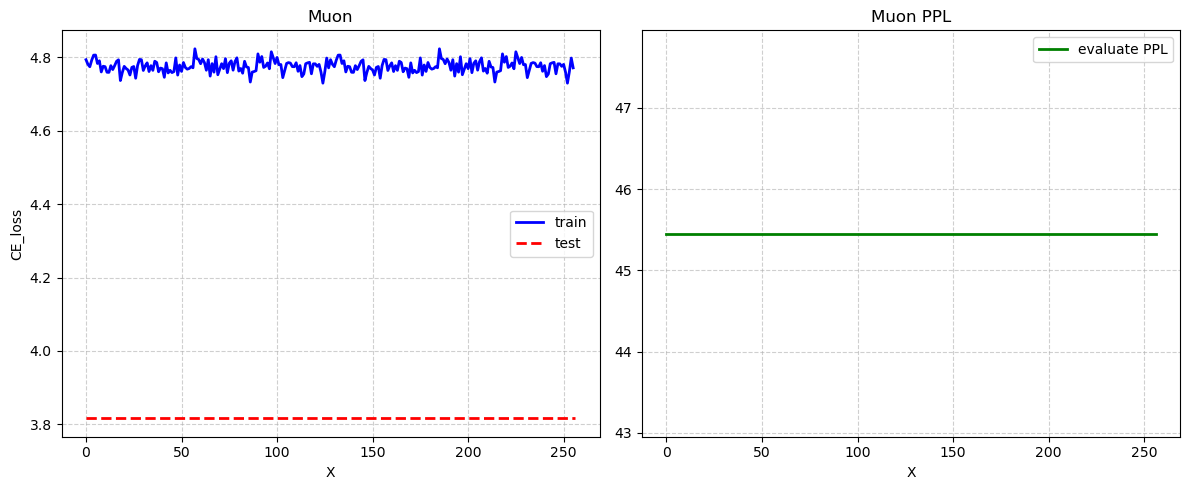

In [132]:
import matplotlib.pyplot as plt

# 创建数据
x = torch.arange(len(train_loss)).tolist()
x_test = (torch.arange(epochs+1) *(len(train_dataloader))).tolist()
y1 = train_loss
y2 = test_loss
y3 = PPL


# 创建1行2列的子图布局
plt.figure(figsize=(12, 5))  

# 第一个子图
plt.subplot(1, 2, 1)  # (行, 列, 位置)
plt.plot(x, y1, 'b-', linewidth=2, label='train')
plt.plot(x_test, y2, 'r--', linewidth=2, label='test')
plt.title('Muon')
plt.xlabel('X')
plt.ylabel('CE_loss')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 第二个子图
plt.subplot(1, 2, 2)
plt.plot(x_test, y3, 'g-', linewidth=2, label='evaluate PPL')
plt.title('Muon PPL')
plt.xlabel('X')
plt.ylabel('')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# 自动调整子图间距
plt.tight_layout()

# 保存图片（可选）
# plt.savefig('dual_plot.png', dpi=300)

# 显示图形
plt.show()